## Import Library

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from torchtext.vocab import GloVe, vocab
import torchtext
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import pickle
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

## Cek Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [ ]:
display(device)
!nvcc --version
!nvidia-smi

## Dataset

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dataset = pd.read_excel("/content/gdrive/My Drive/Skripsi/RealData.xlsx",index_col='time',
                      parse_dates=['time'])

In [ ]:
dataset = dataset.astype({'Cabai Rawit':'float','Cabai Rawit Hijau (kg)':'float','Cabai Rawit Merah (kg)':'float'})
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 363 entries, 2021-01-04 to 2022-07-29
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cabai Rawit             363 non-null    float64
 1   Cabai Rawit Hijau (kg)  363 non-null    float64
 2   Cabai Rawit Merah (kg)  363 non-null    float64
dtypes: float64(3)
memory usage: 11.3 KB


## Parameter

In [ ]:
class Parameter:
    def __init__(self, values):
        for value in values:
            setattr(self, value, values[value])

    def __repr__(self):
        return 'Parameter values:\n' + self.__dict__.__repr__()

In [ ]:
config = Parameter({
    
    # Prerocessing config
    'train_size': 7e-1,
    'test_size': 3e-1,
    'sequence':21,
    
    # Network Models config
    'hidden_size': 128,
    'learning_rate' : 1e-3,

})

config

Parameter values:
{'train_size': 0.7, 'test_size': 0.3, 'sequence': 21, 'hidden_size': 128, 'learning_rate': 0.001}

## Preprocessing

In [ ]:
class PreProcessing:
    def __init__(self, dataset, target):
        
        self.nData, self.nFeature = dataset.shape
        self.target = target
        self.index = [dataset.columns.get_loc(col) for col in dataset if col in target]
        
        self.minMaxValuesDataset = []
        self.xTicksTrain = self.yTicksTrain = self.xTicksTest = self.yTicksTest = None

    def TrainTestSplit(self, dataset, train_size=config.train_size, test_size=config.test_size):

        nData = int(dataset.shape[0]*train_size)
        _X_train = dataset.iloc[:nData, :]
        _y_train = dataset[[self.target]].iloc[:nData, :]
        _X_test = dataset.iloc[nData:, :]
        _y_test = dataset[[self.target]].iloc[nData:, :]
        
        return _X_train, _y_train, _X_test, _y_test

    def MinMaxNormaliasi(self, X_train, y_train, X_test, y_test):
       
        self.minMaxValuesDataset.append(dataset.min(axis=0))
        self.minMaxValuesDataset.append(dataset.max(axis=0))
        
        _X_train = (X_train - dataset.min(axis=0)) / (dataset.max(axis=0) - dataset.min(axis=0))
        _y_train = (y_train - self.minMaxValuesDataset[0][self.index]) / (self.minMaxValuesDataset[1][self.index] - self.minMaxValuesDataset[0][self.index])
        
        _X_test = (X_test - dataset.min(axis=0)) / (dataset.max(axis=0) - dataset.min(axis=0))
        _y_test = (y_test - self.minMaxValuesDataset[0][self.index]) / (self.minMaxValuesDataset[1][self.index] - self.minMaxValuesDataset[0][self.index])
        
        return self.minMaxValuesDataset, _X_train, _y_train, _X_test, _y_test

    def DeNormaliasiMinMax(self, X):
        denorm = (X * (self.minMaxValuesDataset[1][self.index] - self.minMaxValuesDataset[0][self.index]) + self.minMaxValuesDataset[0][self.index])
        return denorm

    def SequenceDataset(self,X_dataset, y_Dataset, seq_len,mode=True):

        X_dataset_values = X_dataset.iloc[:,:].values
        y_Dataset_values = y_Dataset.iloc[:,:].values
        _nRow, _nFeature = X_dataset.shape
        _nStep = seq_len // seq_len
        _X_Dataset, _y_Dataset = [], []
                        
        for i in range(len(X_dataset)-seq_len):
            _X_Dataset.append(X_dataset_values[i:i+seq_len])
            _y_Dataset.append(y_Dataset_values[i+seq_len])
        _Xt_dataset = np.stack(_X_Dataset)
        _yt_dataset = np.array(_y_Dataset)

        if hasattr(X_dataset, 'index'):
            if mode:
                self.xTicksTrain = X_dataset.iloc[:_Xt_dataset.shape[0], :].index
                self.yTicksTrain = y_Dataset.iloc[:_Xt_dataset.shape[0], :].index
            else:
                self.xTicksTest = X_dataset.iloc[:_Xt_dataset.shape[0], :].index
                self.yTicksTest = y_Dataset.iloc[:_Xt_dataset.shape[0], :].index
        
        print('\nData')
        print(f'(N, S, F): ({_Xt_dataset.shape[0]}, {seq_len}, {_Xt_dataset.shape[1]})')
        return np.array(_Xt_dataset), np.array(_yt_dataset)

## LSTM

In [ ]:
import math

class LSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weight()
                
    def init_weight(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x, 
                init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz,fn= x.shape
        hidden_seq = []
        if init_states is None:
            hidden_state, cell_state = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            hidden_state, cell_state = init_states
        HS = self.hidden_size
        for t in range(seq_sz):
              x_t = x[:,t,:]
              # batch the computations into a single matrix multiplication
              gates = x_t.float() @ self.W + hidden_state @ self.U + self.bias
              input_gate, forgate_gate, c_cell_state, output_gate = (
                  torch.sigmoid(gates[:, :HS]), # perhitungan input gate
                  torch.sigmoid(gates[:, HS:HS*2]), # perhitungan forgate gate
                  torch.tanh(gates[:, HS*2:HS*3]), #perhitungangan c'cell state
                  torch.sigmoid(gates[:, HS*3:]), # output
              )
              cell_state = forgate_gate * cell_state + input_gate * c_cell_state
              hidden_state = output_gate * torch.tanh(cell_state)
              cache = Parameter({
              'input_gate': input_gate,
              'forgate_gate': forgate_gate,
              'c_cell_state': c_cell_state,
              'output_gate': output_gate,
               })
              hidden_seq.append(hidden_state.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (hidden_state, cell_state),cache

## Network

In [ ]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__  () 
        self.lstm = LSTM(input_size,hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        _xlstm, (h_n_lstm, c_n_lstm),cache = self.lstm(x, hidden)
        _x = _xlstm[:, -1, :]
        _x = self.fc((_x))
        
        return _x

## MSE

In [ ]:
def MSELoss(output,prediksi):
  MSE = nn.MSELoss()
  return MSE(output,prediksi)

## Training

In [ ]:
Pengujian = PreProcessing(dataset, 'Cabai Rawit')
X_trainPengujian, y_trainPengujian, X_testPengujian, y_testPengujian = Pengujian.TrainTestSplit(dataset)
MinMaxValuesDatasetPengujian, X_trainPengujian, y_trainPengujian, X_testPengujian, y_testPengujian = Pengujian.MinMaxNormaliasi(X_trainPengujian, y_trainPengujian, X_testPengujian, y_testPengujian)


In [ ]:
train_setPengujian = Pengujian.SequenceDataset(X_trainPengujian, y_trainPengujian,config.sequence,1)
test_setPengujian = Pengujian.SequenceDataset(X_testPengujian, y_testPengujian,config.sequence,0)

In [ ]:
dataX_train,dataY_train = train_setPengujian
dataX_test,dataY_test = test_setPengujian
dataX_train,dataY_train = torch.Tensor(np.array(dataX_train)),torch.Tensor(np.array(dataY_train))
dataX_test,dataY_test = torch.Tensor(np.array(dataX_test)),torch.Tensor(np.array(dataY_test))

In [ ]:
data_train = dataX_train,dataY_train
data_test = dataX_test,dataY_test

In [ ]:
y_testPengujian = y_testPengujian.to_numpy()
X_trainPengujian=X_trainPengujian.to_numpy()

In [ ]:
torch.set_printoptions(sci_mode=False)
X_trainNormalized = torch.from_numpy(X_trainPengujian)
y_trainNormalized = torch.from_numpy(np.asarray(y_trainPengujian))
X_trainNormalized.shape,y_trainNormalized.shape

(torch.Size([254, 3]), torch.Size([254, 1]))

In [ ]:
lstm = Network(3,1,1)
lstm.state_dict()

OrderedDict([('lstm.W', tensor([[-0.3183,  0.5415,  0.5284,  0.7083],
                      [-0.1981,  0.4452,  0.0062,  0.4316],
                      [-0.5202,  0.6303, -0.5841, -0.2379]])),
             ('lstm.U', tensor([[-0.3871, -0.9014, -0.3349, -0.7202]])),
             ('lstm.bias', tensor([-0.8943, -0.0850, -0.0174, -0.9725])),
             ('fc.weight', tensor([[-0.5518]])),
             ('fc.bias', tensor([-0.4744]))])

## Epoch

In [ ]:
i=0
cost_train = 0
cost_test = 0
num_epochs = 50
criterion = MSELoss
model = Network(3,1,config.hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20, gamma=0.9)


In [ ]:
def loop_fnPengujian(dataset, model, criterion, optimizer):
    loop = "train"
    cost = 0
    feature, target = dataset
    if loop == "train":
        optimizer.zero_grad()
        output = model(feature, None)
        loss = criterion(output, target)
        cost += loss
        loss.backward()
        optimizer.step()
  
    return cost, output, target

In [ ]:
i, epoch = 0, 150
train_predsPengujian, train_targetsPengujian = np.empty(0, dtype=np.float64), np.empty(0, dtype=np.float64)
test_predsPengujian, test_targetsPengujian = np.empty(0, dtype=np.float64), np.empty(0, dtype=np.float64)
train_costPengujian, test_costPengujian = np.empty(0, dtype=np.float64), np.empty(0, dtype=np.float64)
valid_correct=0

with tqdm(total=epoch) as bar:
    while i < epoch:
        train_lossPengujian, train_outputPengujian, train_targetsPengujian = loop_fnPengujian(data_train, model, criterion, optimizer)
        test_lossPengujian, test_outputPengujian, test_targetsPengujian = loop_fnPengujian(data_test, model, criterion, optimizer)
        train_costPengujian = np.append(train_costPengujian,train_lossPengujian.detach().numpy())
        test_costPengujian = np.append(test_costPengujian, test_lossPengujian.detach().numpy())
        # scheduler.step()
        valid_correct += test_outputPengujian.eq(test_targetsPengujian.view_as(test_outputPengujian)).sum().item()
        train_predsPengujian  = train_outputPengujian
        train_targetsPengujian = train_targetsPengujian
        test_predsPengujian  = test_outputPengujian
        test_targetsPengujian = test_targetsPengujian
        # Print epoch
        i+=1
        # if i % 10 == 0:
        print(f'epoch {i} train: {train_lossPengujian} test: {test_lossPengujian}')
            
        bar.set_description('epoch: %d' % (i))
        bar.update(1)
        

  0%|          | 0/150 [00:00<?, ?it/s]

epoch 1 train: 0.1991792470216751 test: 0.4024730920791626
epoch 2 train: 0.16868692636489868 test: 0.3497277498245239
epoch 3 train: 0.14213144779205322 test: 0.29990342259407043
epoch 4 train: 0.11708375811576843 test: 0.24978332221508026
epoch 5 train: 0.09227252006530762 test: 0.19615478813648224
epoch 6 train: 0.06696223467588425 test: 0.13577601313591003
epoch 7 train: 0.04242049902677536 test: 0.06914663314819336
epoch 8 train: 0.03136179968714714 test: 0.030606497079133987
epoch 9 train: 0.07764386385679245 test: 0.0486331544816494
epoch 10 train: 0.05447239428758621 test: 0.027131684124469757
epoch 11 train: 0.030687062069773674 test: 0.03356066718697548
epoch 12 train: 0.025875505059957504 test: 0.04315144941210747
epoch 13 train: 0.025312349200248718 test: 0.04616250842809677
epoch 14 train: 0.02434924617409706 test: 0.04245680198073387
epoch 15 train: 0.02247815951704979 test: 0.03413435071706772
epoch 16 train: 0.02058464288711548 test: 0.02452724426984787
epoch 17 train: 

In [ ]:
print(f'MSE: {np.around(test_costPengujian.mean(), 10)}')

MSE: 0.0191447475


In [ ]:
train_target_denorm = np.array([], dtype=np.float64)
train_pred_denorm = np.array([], dtype=np.float64)

for x in range(train_targetsPengujian.shape[0]):
    train_target_denorm = np.append(train_target_denorm, Pengujian.DeNormaliasiMinMax(train_targetsPengujian[x].detach().numpy()).values)
    train_pred_denorm = np.append(train_pred_denorm, Pengujian.DeNormaliasiMinMax(train_predsPengujian[x].detach().numpy()).values)

test_target_denorm = np.array([], dtype=np.float64)
test_pred_denorm = np.array([], dtype=np.float64)

for x in range(test_targetsPengujian.shape[0]):
    test_target_denorm = np.append(test_target_denorm, Pengujian.DeNormaliasiMinMax(test_targetsPengujian[x]).values)
    test_pred_denorm = np.append(test_pred_denorm, Pengujian.DeNormaliasiMinMax(test_predsPengujian[x].detach().numpy()).values)

In [ ]:
arr = np.stack((train_pred_denorm, train_pred_denorm), axis=1)

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
arr

array([[68454.51955497, 68454.51955497],
       [66080.77336848, 66080.77336848],
       [64466.27271175, 64466.27271175],
       [63570.80881298, 63570.80881298],
       [63351.95739567, 63351.95739567],
       [62916.32500291, 62916.32500291],
       [62939.03832138, 62939.03832138],
       [62649.17646348, 62649.17646348],
       [62261.17742062, 62261.17742062],
       [64977.27622092, 64977.27622092],
       [67133.10730457, 67133.10730457],
       [68734.33691263, 68734.33691263],
       [70646.5460062 , 70646.5460062 ],
       [71735.83139479, 71735.83139479],
       [72082.109496  , 72082.109496  ],
       [72171.52972519, 72171.52972519],
       [72058.75438452, 72058.75438452],
       [71559.89219248, 71559.89219248],
       [70634.91021097, 70634.91021097],
       [63587.41630614, 63587.41630614],
       [65759.16473567, 65759.16473567],
       [71326.60922408, 71326.60922408],
       [77401.96694434, 77401.96694434],
       [81904.21965718, 81904.21965718],
       [82125.13

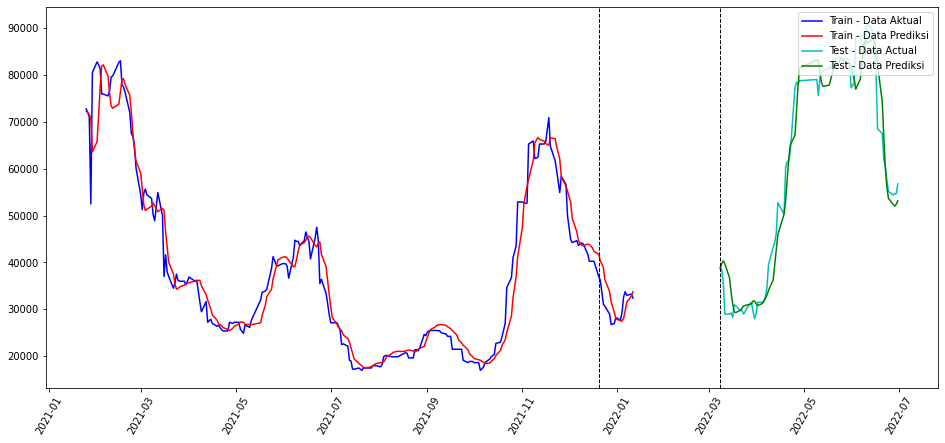

In [ ]:
plt.figure(figsize=(16, 7))
plt.plot(Pengujian.xTicksTrain.values[15:], train_target_denorm[15:], 'b-', label="Train - Data Aktual")
plt.plot(Pengujian.xTicksTrain.values[15:], train_pred_denorm[15:], 'r-', label="Train - Data Prediksi")
plt.plot(Pengujian.xTicksTest.values[15:], test_target_denorm[15:], 'c-', label="Test - Data Actual")
plt.plot(Pengujian.xTicksTest.values[15:], test_pred_denorm[15:], 'g-', label="Test - Data Prediksi")
plt.axvline(Pengujian.xTicksTrain.values[-15], color='k', linestyle="--", linewidth=1)
plt.axvline(Pengujian.xTicksTest[15], color='k', linestyle="--", linewidth=1)
plt.xticks(rotation=60)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.legend(loc='upper right')
plt.show()